**CONFRONTO TRA ALGORITMI PER IL CALCOLO DI SISTEMI LINEARI Ax = b**

Nel seguente programma sono stati implementati i seguenti algoritmi:
- Metodo Cramer e Cramer ottimizzato
- Metodo MEG + algoritmo di sostituzione all'indietro
- Metodo Decomposizione A = LU
- Metodo Built-in di numpy
- Metodo Matrice inversa
- Metodo doolittle
- Metodo Crout


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [29]:
# Con questa funzione vado a calcolare il piu piccolo numero di macchina positivo tale che sommato ad 1 dia unaquantit`a maggiore di 1.  
# Si tratta del numero che si trova tra 1 e il prossimo numero di macchina

In [30]:
def epsilon_machine():
    eps = 1.0
    while eps + 1 > 1:
        eps/=2
    eps *= 2
    return eps

In [31]:
def eliminazione_gauss(A, b):
    A = np.copy(A)
    b = np.copy(b)
    
    n = len(A)
    
    for j in range(n - 1):
        for i in range(j + 1, n):
            m =  A[i, j] / A[j, j]
            
            for k in range(j + 1, n):
                A[i, k] = A[i, k] - m * A[j, k]
            b[i] = b[i] - m * b[j]

    return A, b
            

In [32]:
def sostituzione_indietro(U, b):
    n = len(U)
    x = np.zeros(n)

    if abs(np.prod(np.diag(U))) < epsilon_machine():
        print("Attenzione! Questa matrice potrebbe non avere soluzioni")
    else:
        for i in range(n - 1, -1, -1):
            S = 0

            for j in range(i + 1, n):
                S = S + U[i, j] * x[j]

            x[i] = (b[i] - S) / U[i, i]

    return x

In [33]:
def sostituzione_avanti(L, b):
    # Prendiamo il numero di righe
    n = L.shape[0]

    # Allochiamo spazio per il vettore soluzione
    y = np.zeros_like(b, dtype=np.double)

    # Applichiamo la sostituzione in avanti
    y[0] = b[0] / L[0, 0]

    # Cicliamo al contrario sulle righe(bottom up)
    # Iniziando dalla seconda all'ultima riga
    for i in range(1, n):
        y[i] = (b[i] - np.dot(L[i, :i], y[:i])) / L[i, i]

    return y

In [34]:
def fattorizzazioneLU(A):
    n = len(A)

    U = A.copy()
    L = np.eye(n)

    for i in range(n):
        m = U[i + 1:, i] / U[i, i]
        L[i + 1:, i] = m
        U[i + 1:] = U[i + 1:] - m[:, np.newaxis] * U[i]

    return L, U

In [35]:
def fattorizzazione_doolittle(A):
    # fattorizzazione Lu usando la fattorizzazione Doolittle

    L = np.zeros_like(A)
    U = np.zeros_like(A)
    N = np.size(A, 0)

    for k in range(N):
        L[k, k] = 1
        U[k, k] = (A[k, k] - np.dot(L[k, :k], U[:k, k])) / L[k, k]
        for j in range(k + 1, N):
            U[k, j] = (A[k, j] - np.dot(L[k, :k], U[:k, j])) / L[k, k]
        for i in range(k + 1, N):
            L[i, k] = (A[i, k] - np.dot(L[i, :k], U[:k, k])) / U[k, k]

    return L, U

In [36]:
def matrice_crout(A):
    n = A.shape[0]

    U = np.zeros((n, n), dtype=np.double)
    L = np.zeros((n, n), dtype=np.double)

    for k in range(n):
        L[k, k] = A[k, k] - L[k, :] @ U[:, k]

        U[k, k:] = (A[k, k:] - L[k, :k] @ U[:k, k:]) / L[k, k]
        L[(k + 1):, k] = (A[(k + 1):, k] - L[(k + 1):, :] @ U[:, k]) / U[k, k]

    return L, U


In [37]:
def fattorizzazioneLU_pivoting(A):
    A = np.copy(A)
    n = len(A)

    indice = np.array(range(n))

    for j in range(n - 1):
        max_A = abs(A[j, j])

        indice_pivot = j

        for i in range(j + 1, n):
            if abs(A[i, j] > max_A):
                indice_pivot = i

        # possibile scambio di righe
        if indice_pivot > j:
            for k in range(n):
                A[indice_pivot, k], A[j, k] = A[j, k], A[indice_pivot, k]
            indice[indice_pivot], indice[j] = indice[j], indice[indice_pivot]

        # eleminazione della colonna j-esima

        for i in range(j + 1, n):
            A[i, j] = A[i, j] / A[j, j]

            for k in range(j + 1, n):
                A[i, k] = A[i, k] - A[i, j] * A[j, k]

    L = np.tril(A, - 1) + np.eye(n, n)
    U = np.tril(A)

    return L, U

In [38]:
def fattorizzazioneLU_pivoting_ottimizzato(A):
    A = np.copy(A)
    n = len(A)

    indice = np.array(range(n))

    for j in range(n - 1):
        # individuazione elemento pivot
        indice_pivot = np.argmax(abs(A[j: n, j])) + j

        # eventuale scambio di righe
        if indice_pivot > j:
            A[[indice_pivot, j]] = A[[j, indice_pivot], :]
            indice[[indice_pivot, j]] = indice[[j, indice_pivot]]

        # eliminazione della colonna j-esima
        for i in range(j + 1, n):
            A[i, j] = A[i, j] / A[j, j]
            A[i, j + 1: n] = A[i, j + 1: n] - A[i, j] * A[j, j + 1: n]

    L = np.tril(A, - 1) + np.eye(n, n)
    U = np.tril(A)

    return L, U

In [39]:
def soluzione_gauss(A, b):
    A = np.copy(A)
    b = np.copy(b)

    U, b = eliminazione_gauss(A, b)
    x = sostituzione_indietro(U, b)

    return x

In [40]:
def soluzione_cramer(A, b):
    x = []
    n = len(A)
    detA = np.linalg.det(A)

    for i in range(n):
        Ai = np.copy(A)
        Ai[:, i] = b
        x.append(float(np.linalg.det(Ai) / np.linalg.det(A)))

    return np.copy(list(x))

In [41]:
def soluzione_cramer_ottimizzato(A, b):
    x = []
    n = len(A)
    detA = np.linalg.det(A)

    for i in range(n):
        Ai = np.copy(A)
        Ai[:, i] = b
        x.append(float(np.linalg.det(Ai) / detA))

    return np.copy(list(x))


In [42]:
def soluzione_matrice_inversa(A, b):
    return np.dot(np.linalg.inv(A), b)

In [43]:
def soluzioneLU(A, b):
    L, U = fattorizzazioneLU(A)

    y = sostituzione_avanti(L, b)
    x = sostituzione_indietro(U, y)

    return x

In [44]:
def soluzione_matrice_croute(A, b):
    L, U = matrice_crout(A)

    y = sostituzione_avanti(L, b)
    x = sostituzione_indietro(U, y)
    return x

In [45]:
def soluzione_doolittle(A, b):
    L, U = fattorizzazione_doolittle(A)

    y = sostituzione_avanti(L, b)
    x = sostituzione_indietro(U, y)
    return x

In [46]:
def soluzioneBuildIn(A, b):
    return np.linalg.solve(A, b)

C:\Users\giuse\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\giuse\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\giuse\AppData\Local\Temp/ipykernel_14200/696467790.py:9: RuntimeWarning: invalid value encountered in double_scalars
  x.append(float(np.linalg.det(Ai) / np.linalg.det(A)))


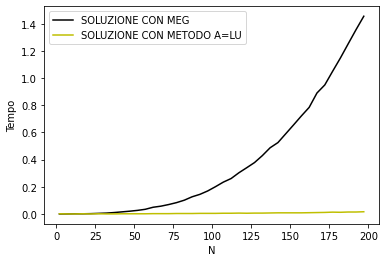

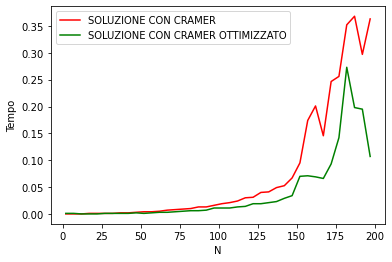

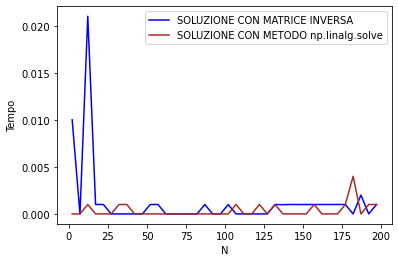

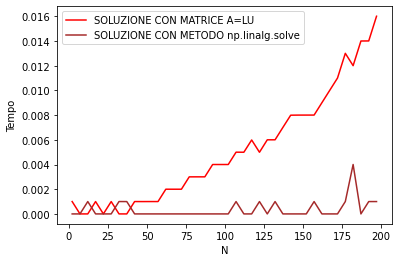

In [47]:
def test_fattorizzazione(N):
    t_Soluzione_Gauss = []
    t_soluzione_ALU_senza_Pivot = []
    t_soluzione_Cramer = []
    t_soluzione_Cramer_ottimizzato = []

    t_soluzione_matrice_inversa = []
    t_soluzione_doolittle = []
    t_soluzione_crout = []
    t_build_in = []


    for n in range(2, N + 1, 5):
        A = (2 * np.random.random((n, n)) - 1) * 10
        b = (2 * np.random.random(n) - 1) * 10

        # effettuo una verifica sul determinante osservando che
        # sia !=0 e quindi la matrice non sia singolare

        while np.linalg.det(A) < epsilon_machine():
            A = (2 * np.random.random((n, n)) - 1) * 10


        # eliminazione di gauss
        tempo_iniziale = time.time()
        x_gauss = soluzione_gauss(A, b)
        tempo_finale = time.time()

        t_Soluzione_Gauss.append(float(tempo_finale - tempo_iniziale))

        
        # cramer
        tempo_iniziale = time.time()
        x_cramer = soluzione_cramer(A, b)
        tempo_finale = time.time()

        t_soluzione_Cramer.append(float(tempo_finale - tempo_iniziale))

        # cramer ottimizzato
        tempo_iniziale = time.time()
        x_cramer_ott = soluzione_cramer_ottimizzato(A, b)
        tempo_finale = time.time()

        t_soluzione_Cramer_ottimizzato.append(float(tempo_finale - tempo_iniziale))


        # matrice inversa
        tempo_iniziale = time.time()
        x_matrice_inversa = soluzione_matrice_inversa(A, b)
        tempo_finale = time.time()

        t_soluzione_matrice_inversa.append(float(tempo_finale - tempo_iniziale))


        # alu senza pivot
        tempo_iniziale = time.time()
        x_soluzione_ALU_senza_Pivot = soluzioneLU(A, b)
        tempo_finale = time.time()

        t_soluzione_ALU_senza_Pivot.append(float(tempo_finale - tempo_iniziale))

       
        # metodo numpy solve
        tempo_iniziale = time.time()
        x_soluzione_Build_In = soluzioneBuildIn(A, b)
        tempo_finale = time.time()

        t_build_in.append(float(tempo_finale - tempo_iniziale))

        # metodo matrice crout
        tempo_iniziale = time.time()
        x_soluzione_crout = soluzione_matrice_croute(A, b)
        tempo_finale = time.time()

        t_soluzione_crout.append(float(tempo_finale - tempo_iniziale))

        # metodo matrice doolittle
        tempo_iniziale = time.time()
        x_soluzione_doolittle = soluzione_doolittle(A, b)
        tempo_finale = time.time()

        t_soluzione_doolittle.append(float(tempo_finale - tempo_iniziale))
    
    plt.figure(1)

    plt.plot(range(2, N + 1, 5), t_Soluzione_Gauss, 'k-',
             label='SOLUZIONE CON MEG')

    plt.plot(range(2, N + 1, 5), t_soluzione_ALU_senza_Pivot, 'y-',
             label='SOLUZIONE CON METODO A=LU')

    plt.xlabel('N')
    plt.ylabel('Tempo')
    plt.legend()
    plt.show()

    plt.plot(range(2, N + 1, 5), t_soluzione_Cramer, 'r-',
             label='SOLUZIONE CON CRAMER')

    plt.plot(range(2, N + 1, 5), t_soluzione_Cramer_ottimizzato, 'g-',
             label='SOLUZIONE CON CRAMER OTTIMIZZATO')

    plt.xlabel('N')
    plt.ylabel('Tempo')
    plt.legend()
    plt.show()

    plt.plot(range(2, N + 1, 5), t_soluzione_matrice_inversa, 'b-',
             label='SOLUZIONE CON MATRICE INVERSA')

    plt.plot(range(2, N + 1, 5), t_build_in, 'brown',
             label='SOLUZIONE CON METODO np.linalg.solve')

    plt.xlabel('N')
    plt.ylabel('Tempo')
    plt.legend()
    plt.show()

    plt.plot(range(2, N + 1, 5), t_soluzione_ALU_senza_Pivot, 'red',
             label='SOLUZIONE CON MATRICE A=LU')

    plt.plot(range(2, N + 1, 5), t_build_in, 'brown',
             label='SOLUZIONE CON METODO np.linalg.solve')

    plt.xlabel('N')
    plt.ylabel('Tempo')
    plt.legend()
    plt.show()
   


test_fattorizzazione(200)

Osservando il grafico dove andiamo a paragonare SOLUZIONE CON MEG e SOLUZIONE CON METODO A=LU è possibile notare che l'adozione del MEG per rendere la matrice piena una triangolare U per poi risolvere il sistema di equazioni lineari con l'algorirmo di sostituzione all'indietro è un metodo più lento rispetto alla decomposizione A = LU

Possiamo notare che il metodo di Cramer che dovrebbe essere più lento rispetto all'eliminazione di Gauss, se implementato con il calcolo del determinante tramite funzioni built-in porta ad una velocità d'esecuzione maggiore.
Nel caso della versione ottimizzata notiamo che l'algoritmo è davvero molto veloce perchè calcoliamo il determinante di A una sola volta e non per ogni Xi.
Importante dire che il metodo di Cramer sia meno stabile del MEG con sostituzione all'indietro oppure rispetto alla decomposizione A = LU, infatti le irregolarità aumentano all'aumentare di N

La massima velocità di esecuzione nei test è data dai metodi  nativi della libreria NUMPY, è osservabile che la risoluzione del sistema tramite la matrice inversa produca dei picchi di instabilità maggiori rispetto all'utilizzo del metodo nativo np.linalg.solve(A, b)

Per quanto riguarda il confronto tra np.linalg.solve(A, b) e la decomposizione A = LU possiamo osservare come l'algoritmo di built-in di NUMPY sia tendenzialmente più veloce però mostra picchi irregolari maggiori